<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/mr0_FID_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install ismrmrd
!pip install MRzeroCore --no-deps
!pip install pydisseqt

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

(FID_seq)=
# Free Induction Decay

In [ ]:
#@title define
def seq_FID(
    fov=(220e-3, 220e-3, 8e-3),
    Nread=256,
    Nphase=1,
    Npart=1,
    FA=None,
    slice_thickness=8e-3,
    experiment_id="FID",
    system=None,
):
    """
    Generate a FID (Free Induction Decay) sequence following the MRzero standard.
    
    Args:
        fov: tuple of floats (x, y, z) in meters
        Nread: int - frequency encoding steps
        Nphase: int - phase encoding steps
        Npart: int - number of partitions
        FA: tensor - flip angle
        slice_thickness: float - slice thickness in meters
        experiment_id: string - experiment identifier
        system: optional scanner system limits
    
    Returns:
        pp.Sequence: Pulseq sequence object
    """
    
    # Use default system if none provided
    if system is None:
        system = pp.Opts(
            max_grad=28, grad_unit='mT/m',
            max_slew=150, slew_unit='T/m/s',
            rf_ringdown_time=20e-6,
            rf_dead_time=100e-6,
            adc_dead_time=20e-6,
            grad_raster_time=10e-6
        )
    
    # Create sequence
    seq = pp.Sequence(system)
    
    # Set sequence definitions according to standard
    seq.set_definition('name', experiment_id)
    seq.set_definition('fov', [fov[0], fov[1], fov[2]])
    seq.set_definition('matrix', [Nread, Nphase, Npart])
    
    # Extract parameters
    fov_x, fov_y, slice_thickness = fov
    
    # Use provided FA or default
    if FA is not None:
        flip_angle = FA.item() if hasattr(FA, 'item') else FA
    else:
        flip_angle = 90 * np.pi / 180  # default 90 degrees for FID
    
    # Define RF events - simple block pulse for FID
    rf1, _, _ = pp.make_sinc_pulse(
            flip_angle=flip_angle, duration=1e-3,
            slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
            delay=0, system=system, return_gz=True
            )
    
    # Define ADC event - simple readout
    adc = pp.make_adc(num_samples=Nread, duration=70e-3, phase_offset=0 * np.pi / 180, delay=0, system=system)
    
    
    # Construct FID sequence (simple: RF pulse followed by ADC)
    seq.add_block(rf1)
    seq.add_block(adc)
    
    seq.write('FID.seq')
    return seq


In [ ]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import matplotlib.pyplot as plt
import torch 

C:\Users\alyar\AppData\Local\Temp\ipykernel_20404\82572627.py:57: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
C:\Users\alyar\AppData\Local\Temp\ipykernel_20404\82572627.py:64: UserWarning: Specified ADC delay 0.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = pp.make_adc(num_samples=Nread, duration=70e-3, phase_offset=0 * np.pi / 180, delay=0, system=system)
C:\Users\alyar\AppData\Local\Temp\ipykernel_20404\82572627.py:71: UserWarning: write(): 1 timing errors found in the sequence
  seq.write('FID.seq')
C:\Users\alyar\github\MRzero-Core\python\MRzeroCore\util.py:829: UserWarning: write(): 1 timing errors found in the sequence
  seq.write('tmp.seq')


DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 1 / 1 - done


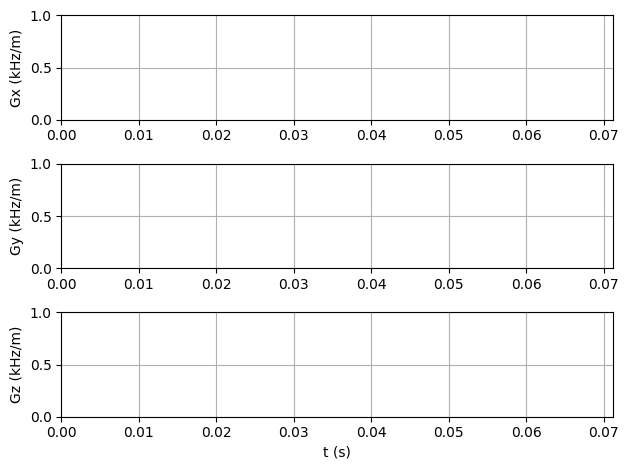

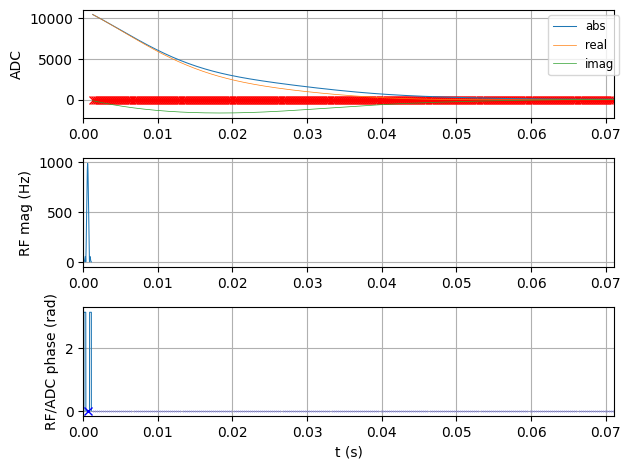

In [ ]:
#@title FID in a brain phantom - sequence
# Define parameters as plain variables
fov = (200e-3, 200e-3, 8e-3)
Nread = 256
Nphase = 1  # FID is 1D readout
FA = torch.tensor(90 * np.pi / 180)  # 90 degree pulse

seq = seq_FID(
    fov=fov,
    Nread=Nread,
    Nphase=Nphase,
    FA=FA,
)

#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq,)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


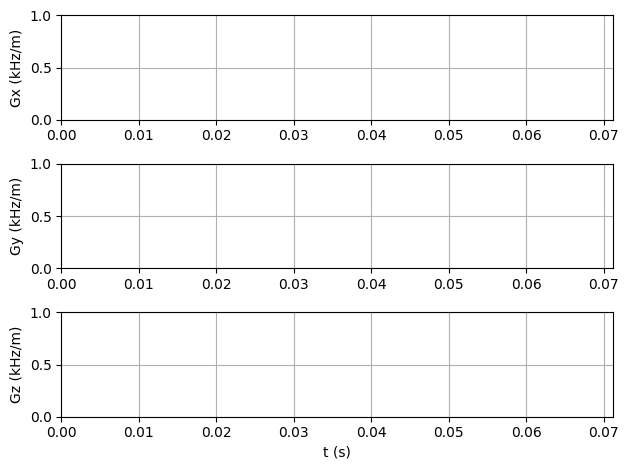

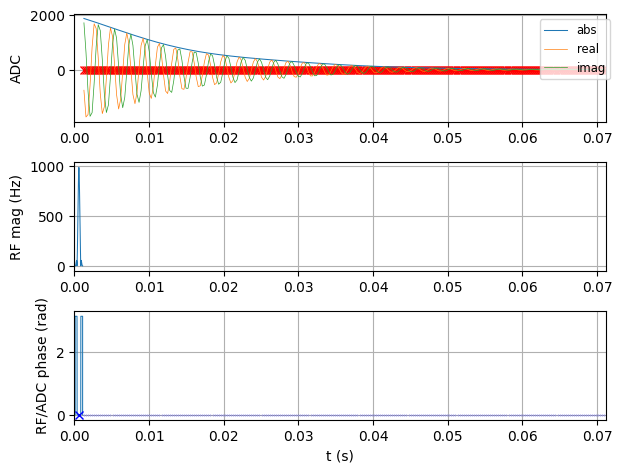

In [3]:
#@title Detailed phantom definition and simulation ation

#@markdown  The B0 inhomogeneity brings you from the rotating frame FID at dB0=0, closer to the lab frame FID at dB0=B0.
#@markdown Try dB0=0 and dB0=500 for a test.
dB0 = 470 #@param {title:'dB0',type:"slider", min:0, max:500, step:10}
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.B0 += dB0
obj_p.D *= 0
#obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file("FID.seq")
# seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with SIGNAL

seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# plt.figure()
# plt.plot(signal.abs().numpy(),'.')
# plt.show()